In [69]:
import abtem
import dask
import matplotlib.pyplot as plt
import numpy as np
from ase.build import bulk
from ase.cluster import Decahedron

(examples:prism_quickstart)=
# PRISM quickstart

In [2]:
abtem.config.set({"device": "gpu"})
abtem.config.set({"fft": "mkl"})

## Create atomic model

In [60]:
carbon = bulk("C", cubic=True)
carbon *= (14, 14, 20)
carbon.positions[:] += np.random.randn(len(carbon), 3) * 0.5
carbon.wrap()

In [61]:
cluster = Decahedron("Cu", 10, 2, 0)
cluster.rotate("x", -30)

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='x [Å]', ylabel='z [Å]'>)

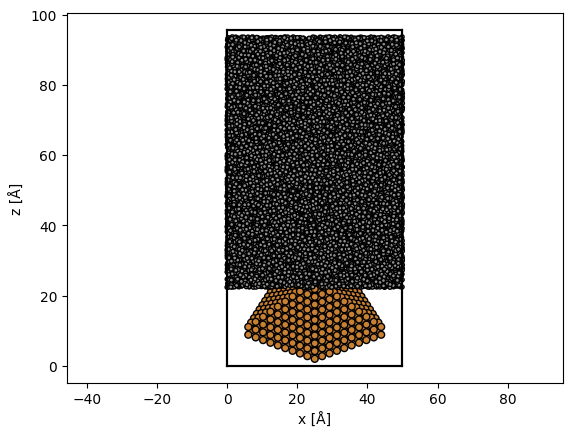

In [44]:
center_height = -45

translated_cluster = cluster.copy()

translated_cluster.translate(np.diag(carbon.cell) / 2 + (0, 0, center_height))

cluster_on_carbon = carbon + translated_cluster

cluster_on_carbon.center(axis=2, vacuum=2)

abtem.show_atoms(cluster_on_carbon, plane="xz", merge=.5)

In [51]:
frozen_phonons = abtem.FrozenPhonons(cluster_on_carbon, 1, {"C": 0.0, "Cu": 0.0})

potential = abtem.Potential(
    frozen_phonons,
    gpts=900,
    projection="infinite",
    slice_thickness=2,
)

In [52]:
s_matrix = abtem.SMatrix(
    potential=potential, energy=200e3, planewave_cutoff=20, interpolation=3
)

s_matrix.build().array

dask.array<wrapped_build_s_matrix, shape=(1, 553, 600, 600), dtype=complex64, chunksize=(1, 79, 600, 600), chunktype=cupy.ndarray>

In [47]:
s_matrix.cutoff_angles

(150.53625640653343, 150.53625640653343)

In [54]:
detectors = abtem.FlexibleAnnularDetector()

measurement = s_matrix.scan(detectors=detectors)

In [55]:
measurement.array

dask.array<mean_agg-aggregate, shape=(178, 178, 100, 1), dtype=float32, chunksize=(60, 60, 100, 1), chunktype=numpy.ndarray>

In [56]:
measurement.compute(num_workers=1)

[########################################] | 100% Completed | 39.26 s


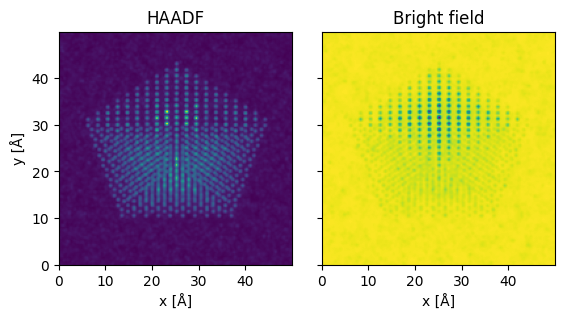

In [57]:
integrated_measurement = abtem.stack(
    (measurement.integrate_radial(50, 150), measurement.integrate_radial(0, 20)),
    axis_metadata=("HAADF", "Bright field"),
)

integrated_measurement.show(explode=True);

In [ ]:
filtered_measurement = integrated_measurement.gaussian_filter(.35)

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

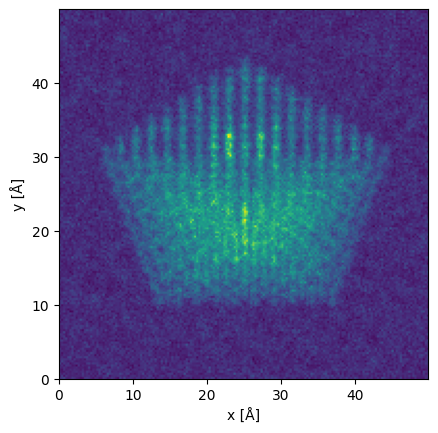

In [67]:

noisy_measurement = filtered_measurement.poisson_noise(dose_per_area=1e5)

noisy_measurement.show(title)

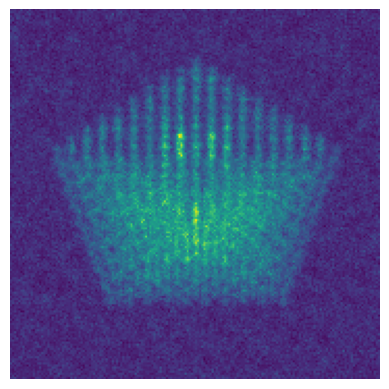

In [68]:
fig, ax = noisy_measurement.show()
ax.axis("off")
plt.savefig("../thumbnails/prism_quickstart.png", bbox_inches="tight", pad_inches=0)